In [1]:
from ellipse_rcnn.pl import EllipseRCNNModule
from ellipse_rcnn.data.prasand import PrasadEllipseDataset
from ellipse_rcnn.data.dataset2 import Data_2_EllipseDataset
from ellipse_rcnn.utils.viz import plot_ellipses, plot_bboxes
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from ellipse_rcnn.core.types import ImageTargetTuple, TargetDict
import torch
import math
from PIL import Image as pil

Processing sample 777
Loading image: D:\Exercises\HIWI\EllipDet-master\Final_dataset\images\im4197_Dataset#2.jpg
original size: 500 x 378
target size_1: 640 x 640


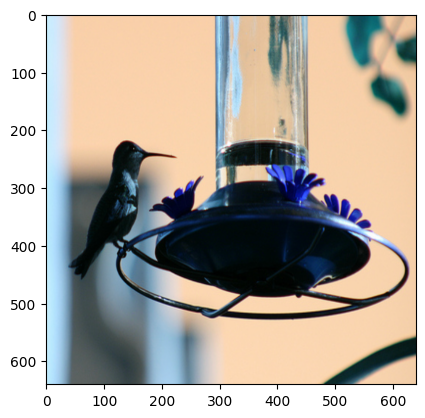

In [7]:
image_dir = r'D:\Exercises\HIWI\EllipDet-master\Final_dataset\images'
annotations_dir = r'D:\Exercises\HIWI\EllipDet-master\Final_dataset\gt'
model_path = r"D:\Exercises\HIWI\ellipse-rcnn-main\checkpoints\loss=val\loss_total=0.59763-e=epoch=07.ckpt"
image_files = sorted([
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if f.endswith(".jpg") or f.endswith(".bmp")  # Include both .jpg and .bmp files
        ])
annotation_files = sorted([
        os.path.join(annotations_dir, f)
        for f in os.listdir(annotations_dir)
        if f.endswith(".txt")
    ])
ds = Data_2_EllipseDataset(
                image_files,
                annotation_files,
            )
idx = 777
image,target = ds[idx]
# image_tensor = torch.from_numpy(image)
image = image.permute(1,2,0).numpy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
#D:\Exercises\HIWI\EllipDet-master\Final_dataset\images\37edge_O24.jpg

In [8]:
# from torchvision import transforms
# image = pil.open(image_files[idx])
# image = image.convert("RGB")
# transform = transforms.ToTensor()

# # Convert the image to a tensor
# image_tensor = transform(image)

In [9]:
print(type(image))
print(image.shape)

<class 'numpy.ndarray'>
(640, 640, 3)


In [10]:
print(f'target: {target}')
print(f'image: {image.size}')

target: {'boxes': tensor([[294.3642, 102.8176, 443.6358, 769.1824],
        [311.6924, 170.2898, 434.3076, 651.7101]]), 'labels': tensor([1, 1]), 'image_id': tensor([777]), 'area': tensor([99469.2969, 59029.4336]), 'iscrowd': tensor([0, 0]), 'ellipse_params': tensor([[6.6000e+01, 3.3500e+02, 3.6900e+02, 4.3600e+02, 1.0631e-01],
        [5.6000e+01, 2.4200e+02, 3.7300e+02, 4.1100e+02, 1.0619e-01]])}
image: 1228800


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


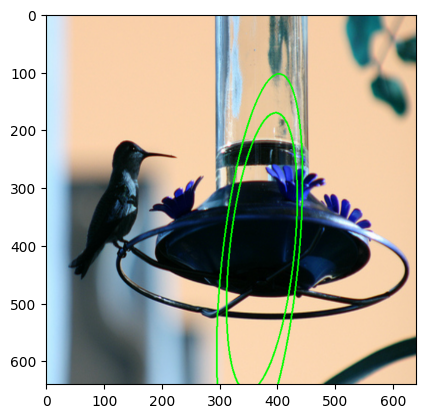

In [11]:
# model = EllipseRCNNModule.load_from_checkpoint(model_path)

# model.eval().cpu()
# with torch.no_grad():
#     pred = model(image.unsqueeze(0))
# score_mask = pred[0]["scores"] > 0.6
# if not len(pred[0]["boxes"][score_mask]) > 0:
#     print(f"No predictions detected for sampled image {idx + 1}.")
# fig, ax = plt.subplots(figsize=(10, 10)) 

# ax.set_aspect("equal")
# ax.axis("off")
# image = image.permute(1, 2, 0) if image.ndim == 3 else image
# ax.imshow(image, cmap="grey")

# ellipses = pred[0]["ellipse_params"][score_mask].view(-1, 5)
# boxes = pred[0]["boxes"][score_mask].view(-1, 4)
# print(f'ellipses: {ellipses}')
# print(f"target: {target['ellipse_params']}")
# # if image.dtype != np.uint8:
#     image = (image * 255).astype(np.uint8) 
ellipse_params = target["ellipse_params"]

for params in ellipse_params:
    # Extracting parameters
    
    axis_length_1 = int(params[0])   # X coordinate of center
    axis_length_2 = int(params[1])   # Y coordinate of center
    center_x = int(params[2])    # Semi-major axis length (half-length)
    center_y = int(params[3])    # Semi-minor axis length (half-length)
    angle = float(params[4]) * (180 / np.pi)   # Convert radians to degrees if necessary
    # print("Image shape:", image.shape)      # Should show H x W x C
    # print("Center:", (center_x, center_y))
    # print("Axes lengths:", (axis_length_1, axis_length_2))
    # print("Angle:", angle)
    
    cv2.ellipse(
    image,
    (center_x, center_y),  # Center
    (axis_length_1, axis_length_2),  # Axes lengths should be half-lengths
    angle,
    0,
    360,
    (0, 255, 0),  # Color
    2)                # Thickness (-1 means filled)

# # Plot ellipses
# plot_ellipses(
#     ellipses,
#     ax=ax,
#     plot_centers=False, # Whehter to plot ellipse centers
#     rim_color="b",
#     alpha=1,
# )
# plot_ellipses(
#             target["ellipse_params"],
#             ax=ax,
#             plot_centers=False,
#             rim_color="r",
#             alpha=1,
#         )
plt.imshow(image)
plt.show()

In [30]:
image.shape

(640, 640, 3)